In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Required Libraries
import numpy as np
import os
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from google.colab import files



# Function to compute GLCM features
def compute_glcm_features(image):
    # Compute GLCM
    glcm = graycomatrix(
        (image * 255).astype(np.uint8),
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    # Extract features from GLCM: contrast, dissimilarity, homogeneity, ASM, correlation
    features = np.hstack([
        graycoprops(glcm, prop).flatten()
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'correlation']
    ])

    return features

# Load images and extract GLCM features
def load_data(data_dir):
    features = []
    labels = []

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)

        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)

                # Read the image as grayscale
                image = io.imread(img_path, as_gray=True)
                if image is not None:
                    # Resize image to a consistent size (e.g., 64x64)
                    image = resize(image, (64, 64))

                    # Compute GLCM features
                    glcm_features = compute_glcm_features(image)

                    # Append features and corresponding label
                    features.append(glcm_features)
                    labels.append(label)  # Assuming subfolder name is the label (e.g., 'positive', 'negative')

    return np.array(features), np.array(labels)

# Example usage to load and extract features from the dataset
data_dir = '/content/drive/MyDrive/HCC - Research/HCC CNN Model/Pos Neg Imges'  # Replace with your dataset path
X, y = load_data(data_dir)

# Print the shape of the extracted features and labels
print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf_glcm = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15)

# Train the classifier
clf_glcm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_glcm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))

# Predict Labels for New Images
def preprocess_new_images(new_data_dir):
    new_features = []

    # Loop over each image in the new data directory
    for img_name in os.listdir(new_data_dir):
        img_path = os.path.join(new_data_dir, img_name)
        try:
            # Read the new image in grayscale mode
            image = io.imread(img_path, as_gray=True)
            if image is not None:
                # Resize image to the same size (e.g., 64x64)
                image = resize(image, (64, 64))

                # Extract GLCM features from the new image
                glcm_features = compute_glcm_features(image)

                # Append features to the list
                new_features.append(glcm_features)
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    # Convert the features list to a numpy array
    return np.array(new_features)

# Path to the new images you want to classify
new_data_dir = '/content/drive/MyDrive/HCC - Research/HCC CNN Model/New'  # Replace with the path to your new images

# Preprocess the new images to extract their GLCM features
new_X = preprocess_new_images(new_data_dir)

# Make predictions using the trained Random Forest model
new_predictions = clf_glcm.predict(new_X)

# Output the predictions for the new images
for i, prediction in enumerate(new_predictions):
    print(f"Image {i + 1} predicted label: {prediction}")


Feature shape: (202, 5)
Labels shape: (202,)
Accuracy: 0.80
                 precision    recall  f1-score   support

Negative Images       0.82      0.74      0.78        19
Positive Images       0.79      0.86      0.83        22

       accuracy                           0.80        41
      macro avg       0.81      0.80      0.80        41
   weighted avg       0.81      0.80      0.80        41

Image 1 predicted label: Negative Images


In [10]:
# Usng K-Fold Cross Validation Method

from sklearn.model_selection import cross_val_score

# Create a Random Forest Classifier
clf_glcm = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15)

# Split data into training and testing sets (80% training, 20% testing

# Perform 5-fold cross-validation
cv_scores_sur = cross_val_score( clf_glcm,X,y,cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores_sur)
print("Mean CV Score:", np.mean(cv_scores_sur))

Cross-Validation Scores: [0.48780488 0.29268293 0.45       0.35       0.525     ]
Mean CV Score: 0.42109756097560974


In [11]:
# List of possible k values
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store mean accuracies for each k
mean_accuracies = []

# Loop through each k value and perform cross-validation
for k in k_values:
    cv_scores = cross_val_score(clf_glcm, X, y, cv=k, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    mean_accuracies.append(mean_accuracy)
    print(f"Mean Accuracy for k={k}: {mean_accuracy:.4f}")

# Find the optimal k
optimal_k = k_values[np.argmax(mean_accuracies)]
print(f"Optimal k: {optimal_k}")

Mean Accuracy for k=2: 0.4802
Mean Accuracy for k=3: 0.3811
Mean Accuracy for k=4: 0.4503
Mean Accuracy for k=5: 0.4211
Mean Accuracy for k=6: 0.4802
Mean Accuracy for k=7: 0.4557
Mean Accuracy for k=8: 0.4650
Mean Accuracy for k=9: 0.5031
Mean Accuracy for k=10: 0.5176
Optimal k: 10


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=10,  # Cross-validation folds
    n_jobs=-1,  # Use all available cores
    scoring='accuracy',
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best parameters:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Use the best model from random search
best_clf = random_search.best_estimator_


Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best cross-validation accuracy: 0.7014705882352941


In [6]:
# Create a DataFrame from features and labels with specific column names
feature_columns = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'correlation']
df_features = pd.DataFrame(X, columns=feature_columns)  # Set column names for features
df_features['Label'] = y  # Add labels to the DataFrame

# Save the DataFrame to a CSV file
output_csv_path = 'glcm_features.csv'  # Define your output path
df_features.to_csv(output_csv_path, index=False)

# Download the CSV file
#files.download(output_csv_path)

In [18]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=9),
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=42, solver='liblinear',)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')

    # Display classification report
    print(f'{name} Classification Report:')
    print(classification_report(y_test, y_pred))
    print('\n' + '-'*50 + '\n')


Random Forest Accuracy: 0.80
Random Forest Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.82      0.74      0.78        19
Positive Images       0.79      0.86      0.83        22

       accuracy                           0.80        41
      macro avg       0.81      0.80      0.80        41
   weighted avg       0.81      0.80      0.80        41


--------------------------------------------------

K-Nearest Neighbors Accuracy: 0.66
K-Nearest Neighbors Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.62      0.68      0.65        19
Positive Images       0.70      0.64      0.67        22

       accuracy                           0.66        41
      macro avg       0.66      0.66      0.66        41
   weighted avg       0.66      0.66      0.66        41


--------------------------------------------------

Logistic Regression Accuracy: 0.61
Logistic Regression Class

In [19]:
from sklearn.metrics import confusion_matrix

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')

    # Display classification report
    print(f'{name} Classification Report:')
    print(classification_report(y_test, y_pred))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} Confusion Matrix:\n{cm}')

    # Extract TN and FP
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity
    specificity = tn / (tn + fp)
    print(f'{name} Specificity: {specificity:.2f}')

    print('\n' + '-'*50 + '\n')


Random Forest Accuracy: 0.80
Random Forest Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.82      0.74      0.78        19
Positive Images       0.79      0.86      0.83        22

       accuracy                           0.80        41
      macro avg       0.81      0.80      0.80        41
   weighted avg       0.81      0.80      0.80        41

Random Forest Confusion Matrix:
[[14  5]
 [ 3 19]]
Random Forest Specificity: 0.74

--------------------------------------------------

K-Nearest Neighbors Accuracy: 0.66
K-Nearest Neighbors Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.62      0.68      0.65        19
Positive Images       0.70      0.64      0.67        22

       accuracy                           0.66        41
      macro avg       0.66      0.66      0.66        41
   weighted avg       0.66      0.66      0.66        41

K-Nearest Neighbors Confusion 

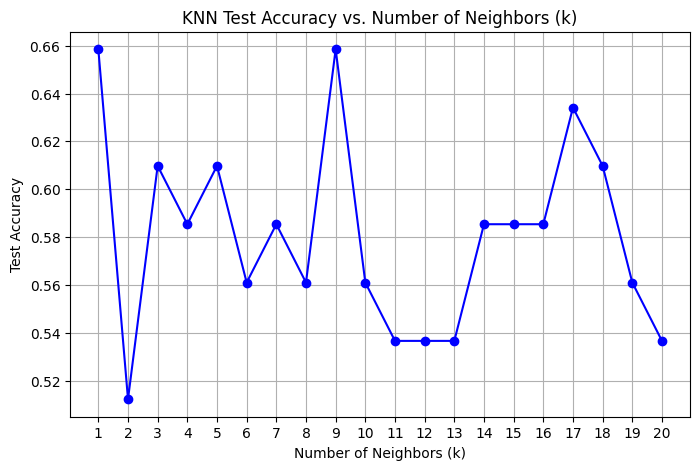

Optimal k: 1 with Test Accuracy: 0.66


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Range of k values to test
k_values = range(1, 21)  # Test k from 1 to 20
test_accuracies = []

# Evaluate KNN for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)

# Plot k vs. accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_values, test_accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Test Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()

# Find the optimal k
optimal_k = k_values[test_accuracies.index(max(test_accuracies))]
print(f"Optimal k: {optimal_k} with Test Accuracy: {max(test_accuracies):.2f}")


Random Forest Cross-Validation Results:
Accuracy for each fold: [0.48780488 0.29268293 0.45       0.35       0.525     ]
Mean CV Accuracy: 0.42
Standard Deviation of CV Accuracy: 0.09


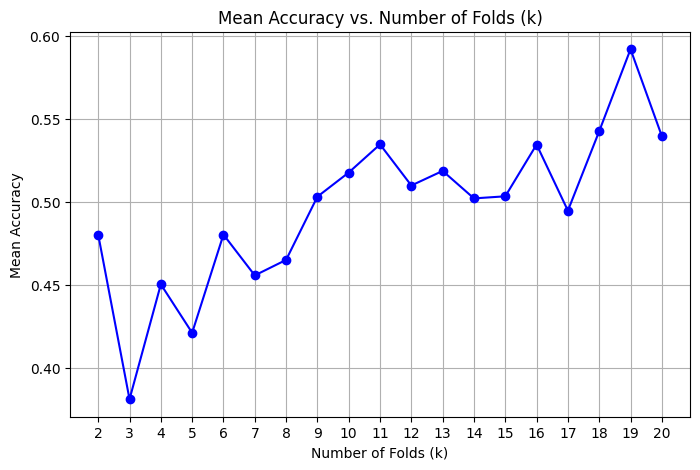

Optimal k: 19 with Mean Accuracy: 0.59


In [ ]:
from sklearn.model_selection import cross_val_score

# Extract the Random Forest classifier
rf_classifier = classifiers["Random Forest"]

# Perform cross-validation (e.g., 5-fold CV)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# Display the cross-validation results
print("Random Forest Cross-Validation Results:")
print(f"Accuracy for each fold: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")


import matplotlib.pyplot as plt

# Range of k values for cross-validation
k_values = range(2, 21)  # k from 2 to 10
mean_accuracies = []

# Perform cross-validation for each k
for k in k_values:
    cv_scores = cross_val_score(rf_classifier, X, y, cv=k, scoring='accuracy')
    mean_accuracies.append(cv_scores.mean())

# Plot mean accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', color='b')
plt.title('Mean Accuracy vs. Number of Folds (k)')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()

# Find the optimal k
optimal_k = k_values[mean_accuracies.index(max(mean_accuracies))]
print(f"Optimal k: {optimal_k} with Mean Accuracy: {max(mean_accuracies):.2f}")


In [ ]:
# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'{name} Training Accuracy: {train_accuracy:.2f}')

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Test Accuracy: {test_accuracy:.2f}')

    # Display classification report for the test set
    print(f'{name} Classification Report:')
    print(classification_report(y_test, y_pred))
    print('\n' + '-'*50 + '\n')


Random Forest Training Accuracy: 1.00
Random Forest Test Accuracy: 0.80
Random Forest Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.82      0.74      0.78        19
Positive Images       0.79      0.86      0.83        22

       accuracy                           0.80        41
      macro avg       0.81      0.80      0.80        41
   weighted avg       0.81      0.80      0.80        41


--------------------------------------------------

K-Nearest Neighbors Training Accuracy: 1.00
K-Nearest Neighbors Test Accuracy: 0.66
K-Nearest Neighbors Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.63      0.63      0.63        19
Positive Images       0.68      0.68      0.68        22

       accuracy                           0.66        41
      macro avg       0.66      0.66      0.66        41
   weighted avg       0.66      0.66      0.66        41


--------------------

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 15)
knn_clf = KNeighborsClassifier(n_neighbors=1)
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42)

# Initialize the Voting Classifier with 'hard' voting
voting_clf = VotingClassifier(estimators=[
    ('Random Forest', rf_clf),
    ('KNN', knn_clf),
    ('Logistic Regression', log_reg_clf)
], voting='hard')

# Train the ensemble classifier
voting_clf.fit(X_train, y_train)

# Make predictions on the test set using the Voting Classifier
y_pred = voting_clf.predict(X_test)

# Calculate accuracy and display the classification report for the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f'Voting Classifier Accuracy: {accuracy:.2f}')
print('Voting Classifier Classification Report:')
print(classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.71
Voting Classifier Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.67      0.74      0.70        19
Positive Images       0.75      0.68      0.71        22

       accuracy                           0.71        41
      macro avg       0.71      0.71      0.71        41
   weighted avg       0.71      0.71      0.71        41



In [ ]:
# Create a DataFrame from features and labels
df = pd.DataFrame(X, columns=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'correlation'])
df['category'] = y

# Save DataFrame to CSV
csv_file_path = '/content/glcm_features.csv'
df.to_csv(csv_file_path, index=False)

# Provide a link to download the CSV file
#files.download(csv_file_path)

# Optional: Print the first few rows of the DataFrame
print(df.head())

     contrast  dissimilarity  homogeneity       ASM  correlation  \
0  690.214534      14.427827     0.302327  0.019281     0.913810   
1  822.393105      15.298859     0.385021  0.095984     0.899575   
2  760.960317      14.070933     0.425102  0.113179     0.898760   
3  764.294395      13.590030     0.435023  0.104808     0.896279   
4  768.354911      14.245784     0.451091  0.151854     0.912695   

          category  
0  Positive Images  
1  Positive Images  
2  Positive Images  
3  Positive Images  
4  Positive Images  


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid: try a range of depths
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40]  # None means no limit on depth
}

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=41)

# Set up Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Print the best max_depth and corresponding score
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best Cross-Validation Score:", grid_search.best_score_)


Best max_depth: None
Best Cross-Validation Score: 0.6643939393939394


In [ ]:
from sklearn.model_selection import GridSearchCV

# Example for tuning Random Forest max_depth and n_estimators
param_grid_rf = {
    'max_depth': [10, 15, 20],
    'n_estimators': [100, 150, 200]
}
grid_search_rf = GridSearchCV(rf_clf, param_grid=param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_rf_clf = grid_search_rf.best_estimator_

# Use best_rf_clf in the Voting Classifier after finding best parameters


In [ ]:
# Required Libraries
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Assume that X and y are already loaded datasets with features and labels
# Replace with your data loading function if needed
# X, y = load_data(data_dir)  # Uncomment this if you have a load_data function

# Standardize features (important for KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN model
knn_clf = KNeighborsClassifier()

# Define the range for n_neighbors to test
param_grid = {'n_neighbors': range(1, 21)}  # Testing values from 1 to 20

# Use GridSearchCV to find the best n_neighbors
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_knn_clf = grid_search.best_estimator_
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Optimal Number of Neighbors: {best_n_neighbors}")
print(f"Best Cross-Validation Score: {best_score:.2f}")

# Train the KNN model with the optimal number of neighbors
best_knn_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_knn_clf.predict(X_test)

# Calculate accuracy and display the classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'KNN Model Accuracy with n_neighbors={best_n_neighbors}: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Optimal Number of Neighbors: 1
Best Cross-Validation Score: 0.71
KNN Model Accuracy with n_neighbors=1: 0.78
Classification Report:
                 precision    recall  f1-score   support

Negative Images       0.78      0.74      0.76        19
Positive Images       0.78      0.82      0.80        22

       accuracy                           0.78        41
      macro avg       0.78      0.78      0.78        41
   weighted avg       0.78      0.78      0.78        41



Optimal Number of Neighbors: 1
Best Cross-Validation Score: 0.71


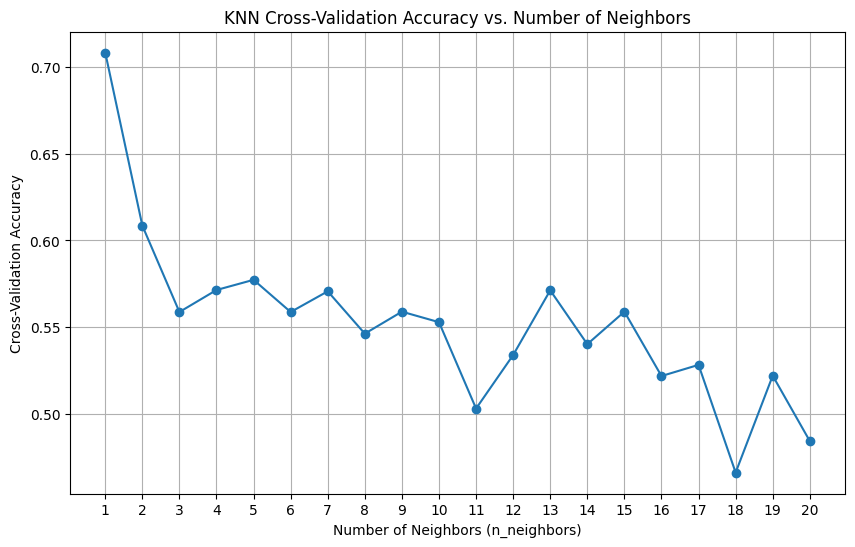

In [ ]:
# Required Libraries
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assume that X and y are already loaded datasets with features and labels
# X, y = load_data(data_dir)  # Uncomment this if you have a load_data function

# Standardize features (important for KNN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define range for n_neighbors to test
neighbor_range = range(1, 21)  # Testing values from 1 to 20
cv_scores = []

# Compute cross-validation score for each value of n_neighbors
for n in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal number of neighbors that yields the highest cross-validation score
optimal_n = neighbor_range[np.argmax(cv_scores)]
print(f"Optimal Number of Neighbors: {optimal_n}")
print(f"Best Cross-Validation Score: {max(cv_scores):.2f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Cross-Validation Accuracy vs. Number of Neighbors')
plt.xticks(neighbor_range)
plt.grid(True)
plt.show()
